# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать классический перцептрон, немного улучшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [382]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
from sklearn.metrics import accuracy_score

In [383]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        if len(pts) != 0:
            x, y = list(zip(*pts))
            plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [429]:
class Perceptron:
    def __init__(self, iterations=100, lr=0.001):
        self.lr = lr
        self.iterations = iterations
        self.w = None
    
    def fit(self, X, y):
        X_ = np.ones((len(X), X.shape[1] + 1))
        X_[:, 1:] = X
        #self.w = np.ones([X_.shape[1], 1]) * 0.0001
        self.w = np.random.normal(0, 0.001, size=X_.shape[1])
        predictions = np.sign(np.dot(X_, self.w))
        it = 0
        while(it < self.iterations):
            wrong_indices = np.argwhere(predictions.flatten() != y).flatten()
            if len(wrong_indices) == 0:
                break
            next_step_index = np.random.randint(0, wrong_indices.shape[0]) 
            self.w += self.lr * (X_[next_step_index]*y[next_step_index]).reshape(self.w.shape)
            predictions = np.sign(np.dot(X_, self.w))
            it += 1
            
    def predict(self, X):
        X_ = np.ones((len(X), X.shape[1] + 1))
        X_[:, 1:] = X
        return np.sign(np.dot(X_, self.w)).flatten().astype(np.int64)

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

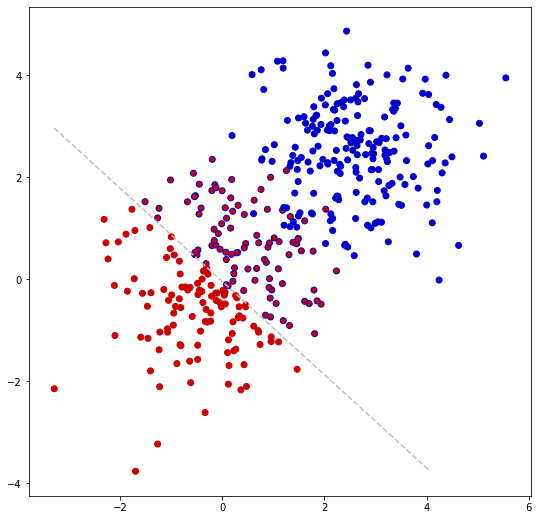

In [430]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
true_labels = np.where(true_labels == 0, -1, true_labels)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

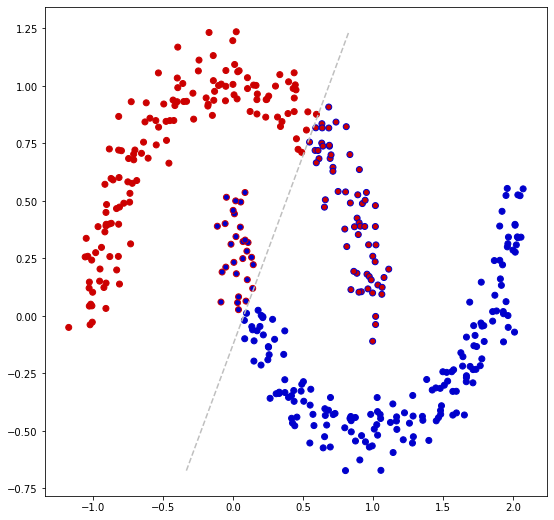

In [431]:
X, true_labels = make_moons(400, noise=0.075)
true_labels = np.where(true_labels == 0, -1, true_labels)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

Реализуем перцептрон с карманом.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [425]:
class PerceptronBest:
    def __init__(self, iterations=100, lr=0.001):
        self.lr = lr
        self.iterations = iterations
        self.w = None
        self.best_accuracy = 0
    
    def fit(self, X, y):
        X_ = np.ones((len(X), X.shape[1] + 1))
        X_[:, 1:] = X
        #weights = np.ones([X_.shape[1], 1]) * 0.0001
        weights = np.random.normal(0, 0.001, size=X_.shape[1])
        predictions = np.sign(np.dot(X_, weights))
        it = 0
        while(it < self.iterations):
            wrong_indices = np.argwhere(predictions.flatten() != y).flatten() 
            if len(wrong_indices) == 0:
                self.w = np.copy(weights)
                break
            next_step_index = np.random.randint(0, wrong_indices.shape[0]) 
            weights += self.lr * (X_[next_step_index]*y[next_step_index]).reshape(weights.shape)
            predictions = np.sign(np.dot(X_, weights))
            acc = accuracy_score(predictions, y)
            it += 1
            if acc > self.best_accuracy:
                self.best_accuracy = acc
                self.w = np.copy(weights)
            
    def predict(self, X):
        X_ = np.ones((len(X), X.shape[1] + 1))
        X_[:, 1:] = X
        return np.sign(np.dot(X_, self.w)).flatten().astype(np.int64)

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

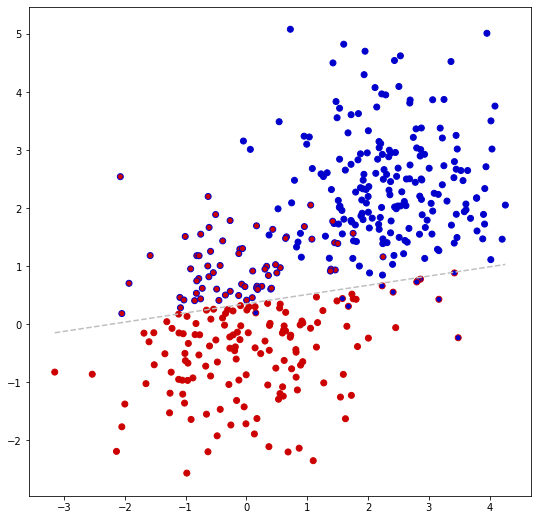

In [426]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
true_labels = np.where(true_labels == 0, -1, true_labels)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

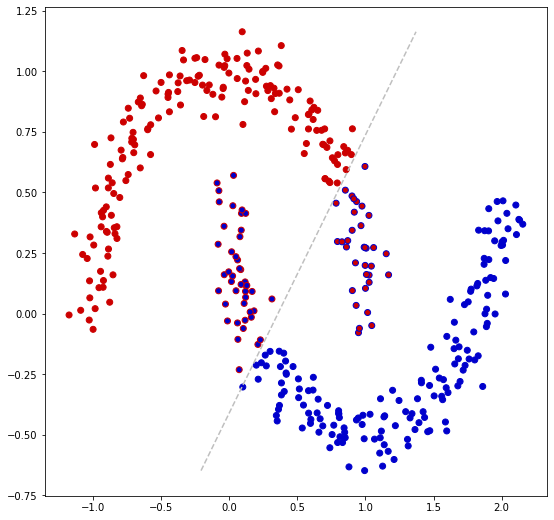

In [427]:
X, true_labels = make_moons(400, noise=0.075)
true_labels = np.where(true_labels == 0, -1, true_labels)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [402]:
# в качестве первой координаты я взяла среднее от индексов нулевых элементов, сдвинутое налево
# влево или вправо в зависимости от класса, в качестве второй координаты взяла сумму ненулевых 
# элементов, также сдвинутое вверх или вниз в зависимости от класса
def transform_images(images, labels):
    X = np.zeros((images.shape[0], 2))
    uni_labels = np.unique(labels)
    for i in range(images.shape[0]):
        im = images[i].flatten()
        msk = [im == 0]
        if labels[i] == uni_labels[0]:
            X[i, 0] = np.mean(msk) - 0.05
            X[i, 1] = np.sum(im[im != 0]) - 5
        else:
            X[i, 0] = np.mean(msk) + 0.05
            X[i, 1] = np.sum(im[im != 0]) + 5
    return X

def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images, labels)
    return X, labels

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Точность хотя бы одного из классификаторов на тестовой выборке должна быть больше 80%

In [403]:
X, y = get_digits()
y = np.where(y == 1, -1, y)
y = np.where(y == 5, 1, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

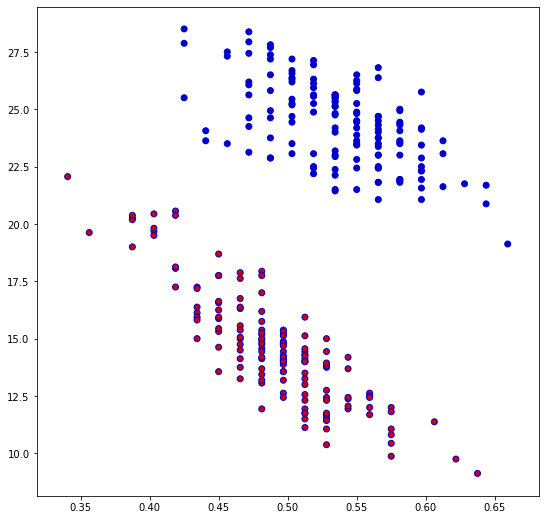

Accuracy: 0.5068493150684932


In [411]:
c = Perceptron(iterations=2000, lr=0.001)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

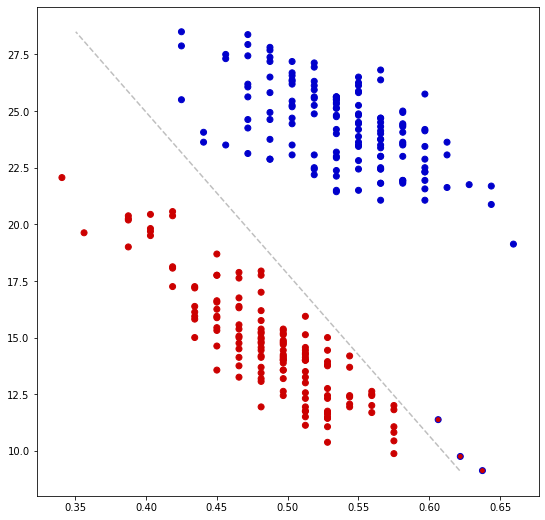

Accuracy: 0.9452054794520548


In [353]:
c = PerceptronBest(iterations=100000, lr=1e-6)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [420]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    y = np.where(y == y0, -1, y)
    y = np.where(y == y1, 1, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = Perceptron(iterations=200)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.5021134501921047


In [428]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    y = np.where(y == y0, -1, y)
    y = np.where(y == y1, 1, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.5348387892040216
